In [1]:
import datetime
import sys
import time

from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

import os
#os.chdir("ws/")

## Train a SSD object detector with the KITTI Dataset
## Agenda

0) SSD (Single Shot Detection)
1) KITTI Dataset
2) MiniKITTI hands-on
3) Training example
4) Detections


## 1) SSD

### Flashback from 30 min:

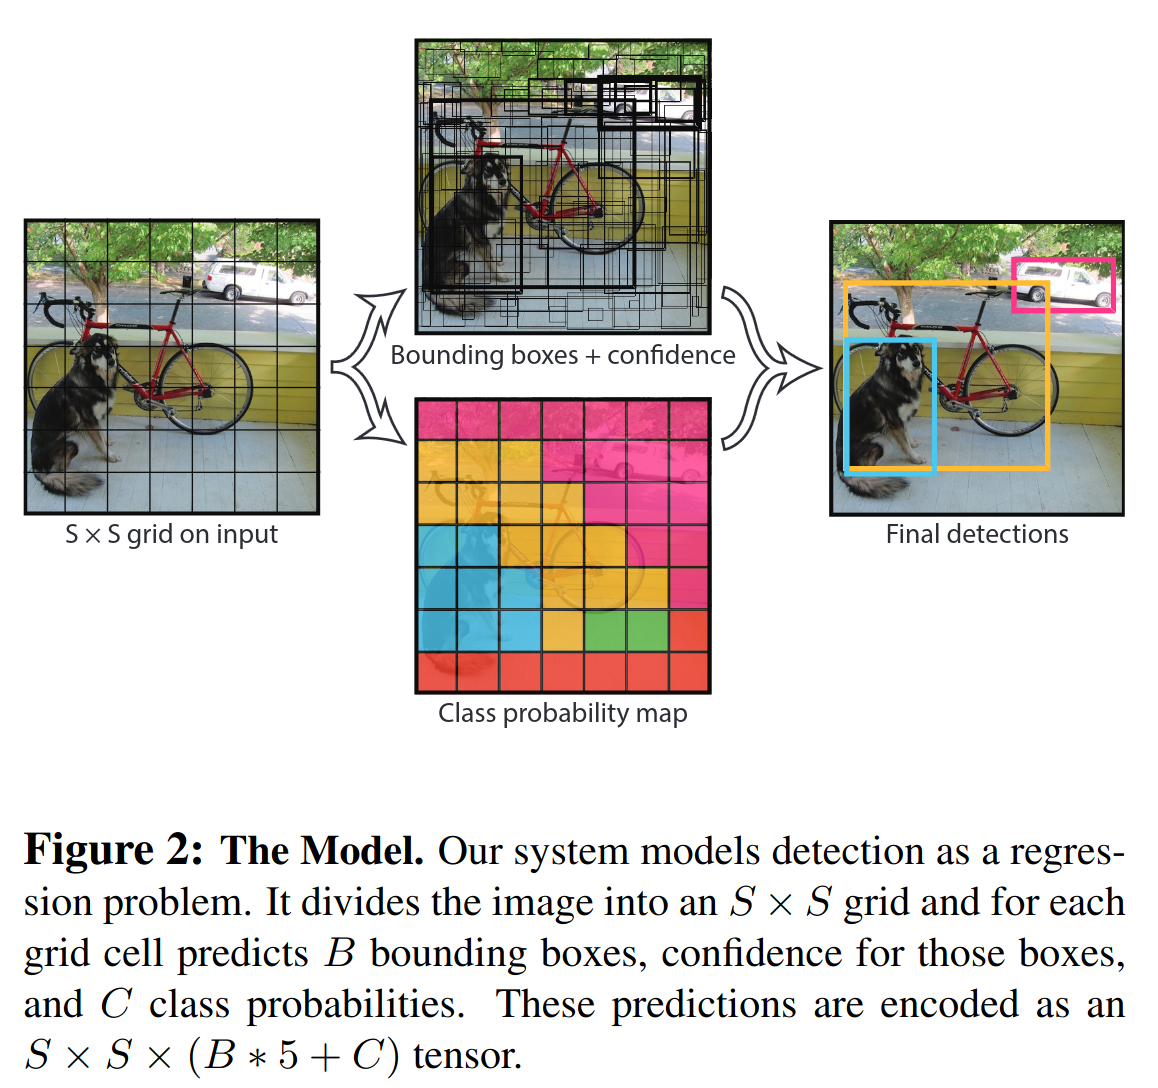


### Objects are detected in 3 scales: 13x13, 26x26, 52x52
- 3 Boxes are predicted for each cell

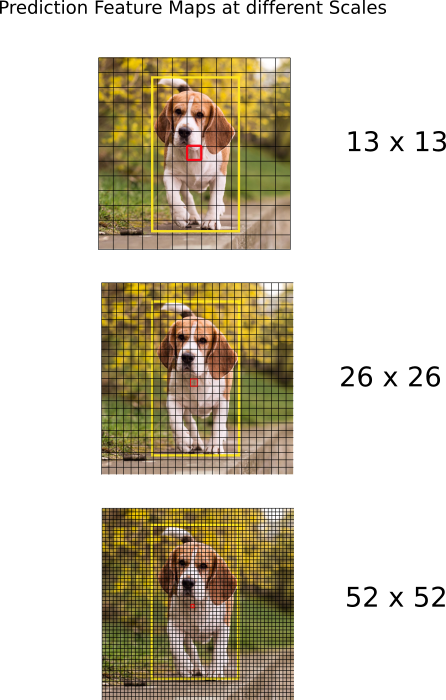



### Predicted boxes with respect to anchors
- Anchors are defined in an offline step

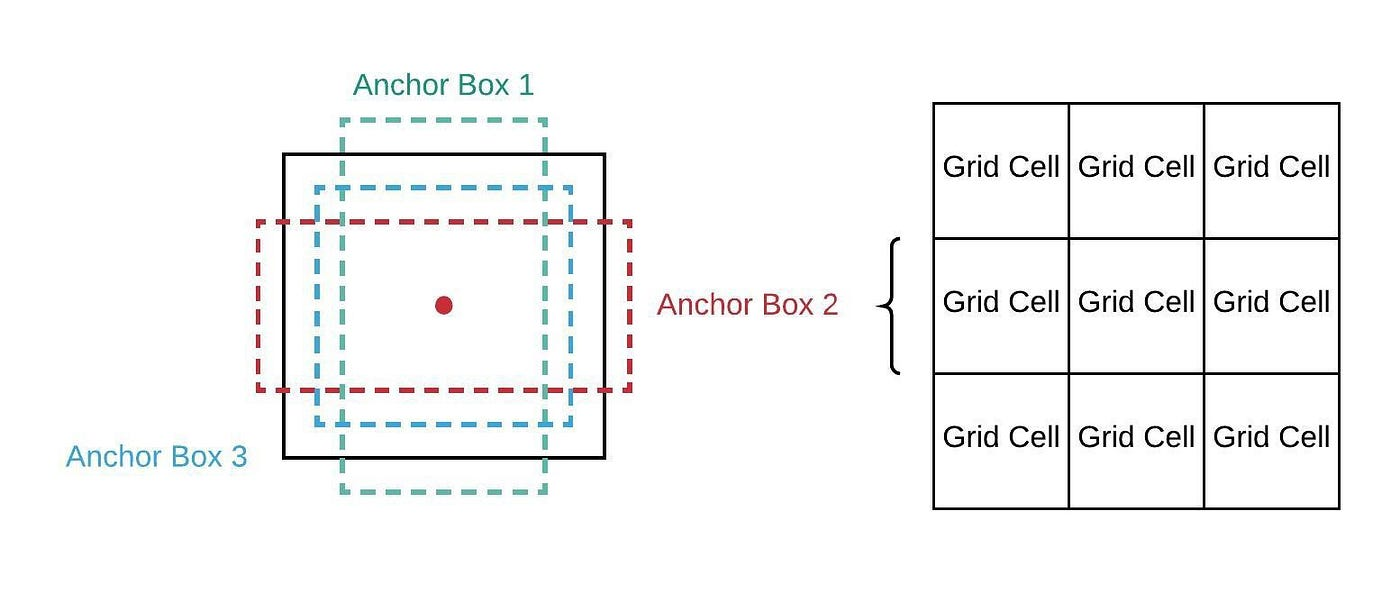


### Nowadays: YOLOV8
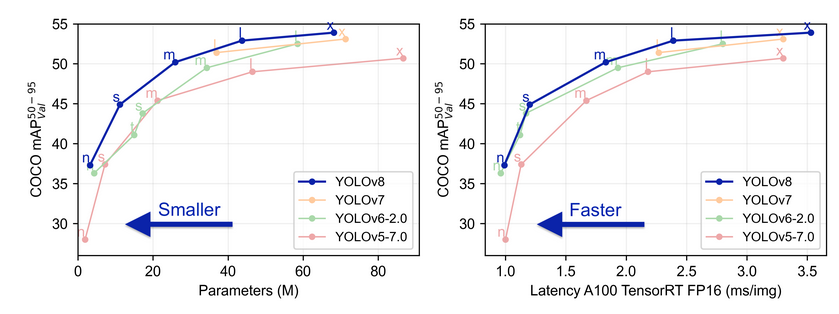

## 2) KITTI Dataset

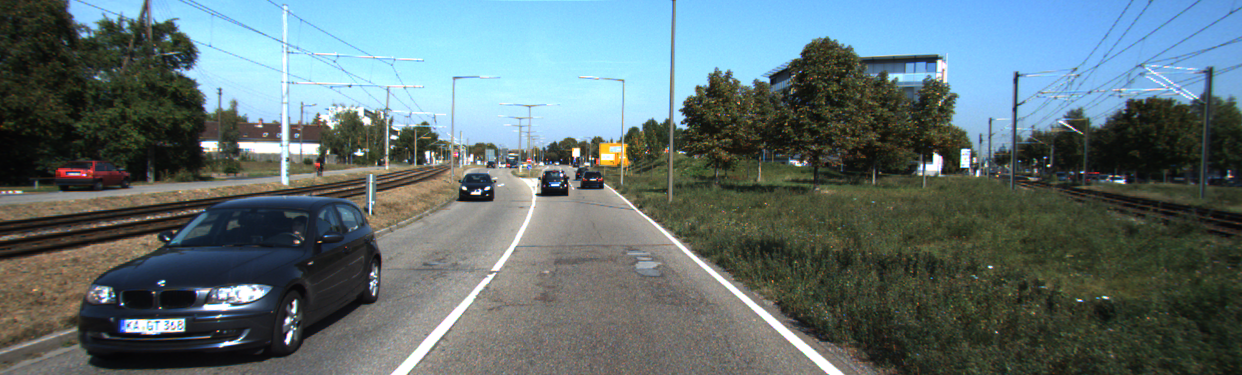

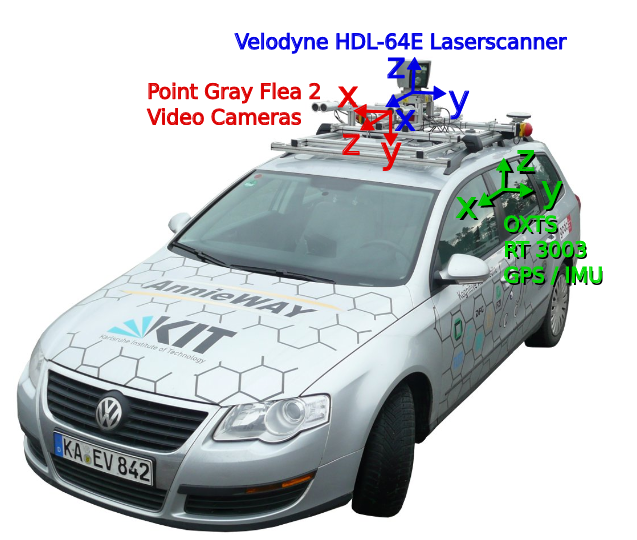


## 3) MiniKITTI hands-on

In [2]:
#from models import *
from utils.datasets import *
from utils.parse_config import *
from utils.utils import *
from utils.models import *

In [3]:
def transform_coordinates(xc,yc,w,h):
    x1 = xc-w/2
    y1 = yc-h/2
    return x1,y1,w,h

In [4]:
opt = dict()
opt["image_folder"] = "kitti/test.txt"
opt["class_path"] = "kitti/classes.names"
opt["batch_size"] = 1
opt["n_cpu"] = 8
opt["img_size"] = 200

In [5]:
classes = load_classes(opt["class_path"])  # Extracts class labels from file
print(classes)

['Car']


In [6]:
dataloader = DataLoader(ListDataset(opt["image_folder"], img_size=opt["img_size"], transform=None,
                                        num_classes=int(len(classes)), multiscale=False),
                            batch_size=opt["batch_size"],
                            shuffle=False,
                            num_workers=opt["n_cpu"],
                            )

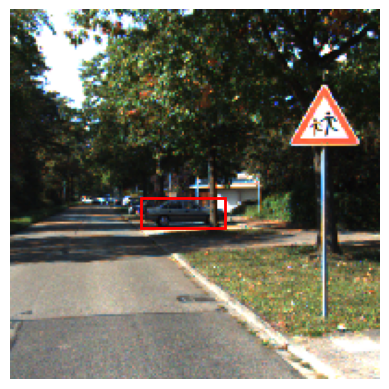

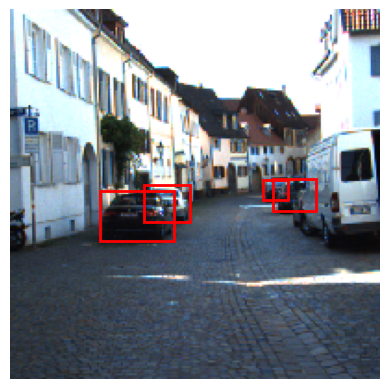

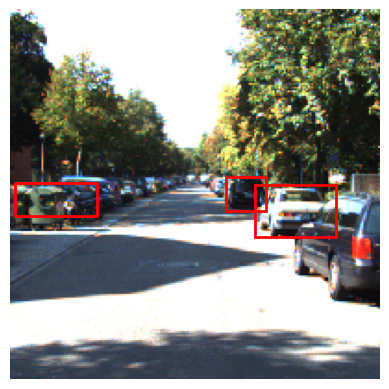

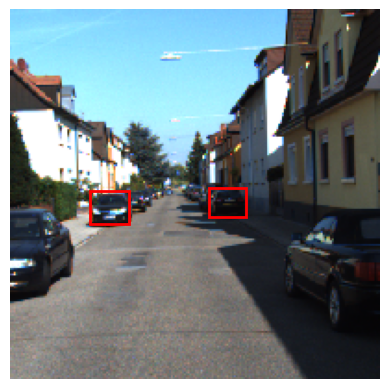

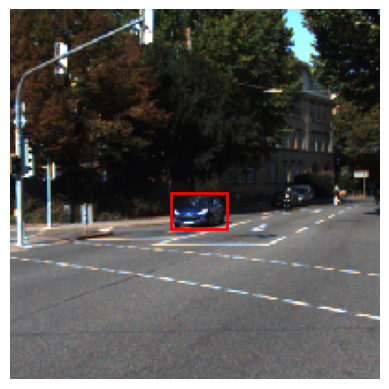

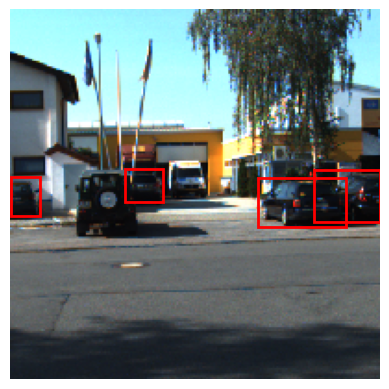

In [7]:
for batch_i, (img_paths, input_imgs, targets) in enumerate(dataloader):
    img = np.transpose(np.array(input_imgs[0]), (1,2,0))
    fig, axs = plt.subplots(1)
    axs.imshow(img)
    for target in targets[0]:
        cls = target[1]
        x1 = float(target[2]*opt["img_size"])
        y1 = float(target[3]*opt["img_size"])
        x2 = float(target[4]*opt["img_size"])
        y2 = float(target[5]*opt["img_size"])
        x1,y1,w,h = transform_coordinates(x1,y1,x2,y2)
        bbox = patches.Rectangle((x1,y1),w,h, linewidth=2, edgecolor="r", facecolor="none")
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        axs.add_patch(bbox)
    if batch_i == 5:
        break


## 4) Training
## 5) Detect


In [8]:
opt = dict()
opt["image_folder"] = "kitti/test.txt"
opt["model_def"] = "config/ssd-kitti.cfg"
opt["weights_path"] = "ssd.pth"
opt["class_path"] = "kitti/classes.names"
opt["batch_size"] = 1
opt["n_cpu"] = 8
opt["img_size"] = 300
opt["conf_thres"] = 0.8
opt["nms_thres"] = 0.4

for key in opt:
    print(f"{key}: {opt[key]}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)

# Set up model
model = SSD(opt["model_def"], num_classes=1).to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(opt["weights_path"], map_location=torch.device("cuda:0")))

# Set in evaluation mode
model.eval()

classes = load_classes(opt["class_path"])  # Extracts class labels from file

dataloader = DataLoader(ListDataset(opt["image_folder"], img_size=opt["img_size"], transform=None,
                                    num_classes=int(len(classes)), multiscale=False),
                        batch_size=opt["batch_size"],
                        shuffle=False,
                        num_workers=opt["n_cpu"],
                        )

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

print("\nPerforming object detection:")
prev_time = time.time()

image_folder: kitti/test.txt
model_def: config/ssd-kitti.cfg
weights_path: ssd.pth
class_path: kitti/classes.names
batch_size: 1
n_cpu: 8
img_size: 300
conf_thres: 0.8
nms_thres: 0.4

Performing object detection:


In [9]:
imgs = [] #Stores images
imgs_paths = []  # Stores image paths
img_detections = []  # Stores detections for each image index

prev_time = time.time()
for batch_i, (img_paths, input_imgs, targets) in enumerate(dataloader):
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        #print(f'input imgs shape:{input_imgs.shape}')
        detections = model(input_imgs, 'eval')
        print(detections[0,1,...])
        #print(f'detections shape before: {detections}')
        #detections = non_max_suppression(detections, opt["conf_thres"], opt["nms_thres"])
        #print(f'detections shape: {detections}')
        
    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.append(input_imgs)
    imgs_paths.append(img_paths)
    print(f'Here are the detections: {detections}')
    img_detections.append(detections[0,1,...]) #(200,5)

    
print(f'len of imgs: {len(imgs)}')
#print(f'single detection shape: {img_detections[0].shape}')


tensor([[0.7527, 0.3888, 0.4738, 0.5622, 0.6075],
        [0.3907, 0.3794, 0.4431, 0.6379, 0.6449],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	+ Batch 0, Inference Time: 0:00:02.706635
Here are the detections: tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.00

/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:240: UserWarning: An output with one or more elements was resized since it had shape [9], which does not match the required output shape [2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.index_select(x1, 0, idx, out=xx1)
/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:241: UserWarning: An output with one or more elements was resized since it had shape [9], which does not match the required output shape [2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can exp

tensor([[0.9350, 0.6875, 0.4432, 0.8889, 0.5914],
        [0.7722, 0.8501, 0.4274, 1.0182, 0.5677],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	+ Batch 5, Inference Time: 0:00:00.038861
Here are the detections: tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.00

/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:240: UserWarning: An output with one or more elements was resized since it had shape [9], which does not match the required output shape [1]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.index_select(x1, 0, idx, out=xx1)
/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:241: UserWarning: An output with one or more elements was resized since it had shape [9], which does not match the required output shape [1]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can exp

tensor([[0.9409, 0.4389, 0.4597, 0.5350, 0.5490],
        [0.4522, 0.5749, 0.4206, 0.6913, 0.5181],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	+ Batch 11, Inference Time: 0:00:00.035332
Here are the detections: tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0

/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:240: UserWarning: An output with one or more elements was resized since it had shape [4], which does not match the required output shape [1]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.index_select(x1, 0, idx, out=xx1)
/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:241: UserWarning: An output with one or more elements was resized since it had shape [4], which does not match the required output shape [1]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can exp

tensor([[0.9970, 0.0593, 0.4525, 0.2273, 0.5788],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	+ Batch 17, Inference Time: 0:00:00.035548
Here are the detections: tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0

/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:240: UserWarning: An output with one or more elements was resized since it had shape [5], which does not match the required output shape [2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.index_select(x1, 0, idx, out=xx1)
/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/utils/ssd_box_utils.py:241: UserWarning: An output with one or more elements was resized since it had shape [5], which does not match the required output shape [2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can exp

tensor([[0.9765, 0.0214, 0.4744, 0.2207, 0.6484],
        [0.8710, 0.1506, 0.4638, 0.2579, 0.5710],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	+ Batch 23, Inference Time: 0:00:00.039773
Here are the detections: tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0

In [11]:
print(f'Number of detections processed: {len(img_detections)}')
# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
# Iterate through images and save plot of detections
print(f' img_detections[0]: {img_detections[0]}')
for img_i, (img_, path, detections) in enumerate(zip(imgs, imgs_paths, img_detections)):

    print("(%d) Image: '%s'" % (img_i, path))
    path = path[0]
    img_ = img_.squeeze(0)
    #print(f'Here are the detections again: {detections}')
    # Create plot
    #img = np.array(Image.open(path))
    #print(f'img shape: {img_.shape}')
    #print(f'detections shape: {detections.shape}')

    img = np.transpose(img_.detach().cpu().numpy(), (1,2,0))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        #print(detections[0], opt["img_size"], img.shape[:2])
        #print(f'detections[...,1] : {detections[...,1:]}')
        #print(f'img_.shape[1]: {img_.shape[1]}')
        detections_ = detections.clone()
        detections_[...,1:] = detections[...,1:] * img_.shape[1]
        #detections = rescale_boxes(detections, opt["img_size"], img.shape[:2])
        #unique_labels = detections[:, -1].cpu().unique()
        unique_labels = 0
        n_cls_preds = 1
        bbox_colors = random.sample(colors, n_cls_preds)
        #for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        for conf, x1, y1, x2, y2 in detections_:
            
            if conf > 0.6:
                #print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))
    
                #print(f'conf: {conf}')
                #print(f'x1: {x1}, y1: {y1}, x2:{x2}, y2:{y2}')
                box_w = x2 - x1
                box_h = y2 - y1
    
                #color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                color = bbox_colors[0]
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=classes[0],
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )
    
    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(path).split(".")[0]
    if not os.path.exists("./output_yolo"): os.mkdir("./output_yolo")
    output_path = os.path.join("output_yolo", f"{filename}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.close()

Number of detections processed: 34

Saving images:
 img_detections[0]: tensor([[0.7527, 0.3888, 0.4738, 0.5622, 0.6075],
        [0.3907, 0.3794, 0.4431, 0.6379, 0.6449],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
(0) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002100.png',)'
(1) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002101.png',)'
(2) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/im

/tmp/ipykernel_3805/1088773675.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)
/tmp/ipykernel_3805/1088773675.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


(21) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002129.png',)'
(22) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002130.png',)'
(23) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002131.png',)'
(24) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002132.png',)'
(25) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002134.png',)'
(26) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti/images/test/002135.png',)'
(27) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>